Depth Map Generation

In [ ]:
!pip install timm
!pip install open3d


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the file ID and the destination path
file_id = '1PE3r-ve0FOOMEwIzZJfEo5PXH6KtDZOF'
destination = '/Myfood.zip'

# Use gdown to download the file
!pip install gdown
import gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

# Unzip the downloaded file
import zipfile
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Now you can access the dataset at /content/dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=1PE3r-ve0FOOMEwIzZJfEo5PXH6KtDZOF
From (redirected): https://drive.google.com/uc?id=1PE3r-ve0FOOMEwIzZJfEo5PXH6KtDZOF&confirm=t&uuid=e195ea62-50aa-4b1a-92d8-89753a703fc8
To: /Myfood.zip
100%|██████████| 1.18G/1.18G [00:26<00:00, 43.9MB/s]


In [ ]:
import cv2
import torch
import urllib.request
from PIL import Image

import matplotlib.pyplot as plt

filename = 'dataset/images/test_set/apple/apple (1).jpg'


In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:05<00:00, 265MB/s]


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

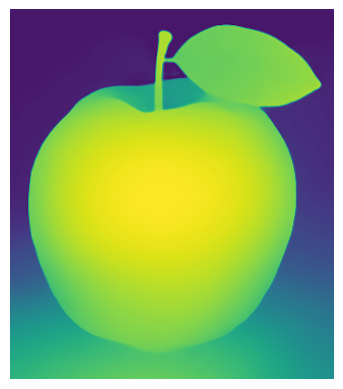

In [ ]:
plt.imshow(output)
plt.axis('off')  # Hide axes
plt.show()

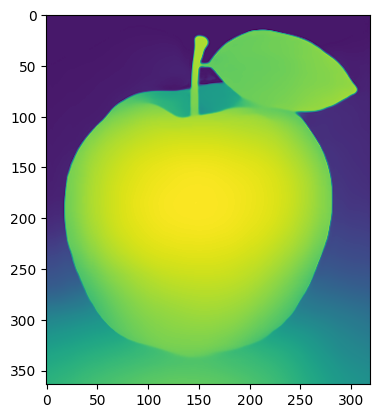

In [ ]:
import numpy as np

min_val = np.min(output)
max_val = np.max(output)
normalized_depth = (output - min_val) / (max_val - min_val) * 255

# Convert to uint8
depth_image = normalized_depth.astype(np.uint8)
cv2.imwrite('/content/depth_map.png', depth_image)

plt.imshow(depth_image)

Point Cloud Generation

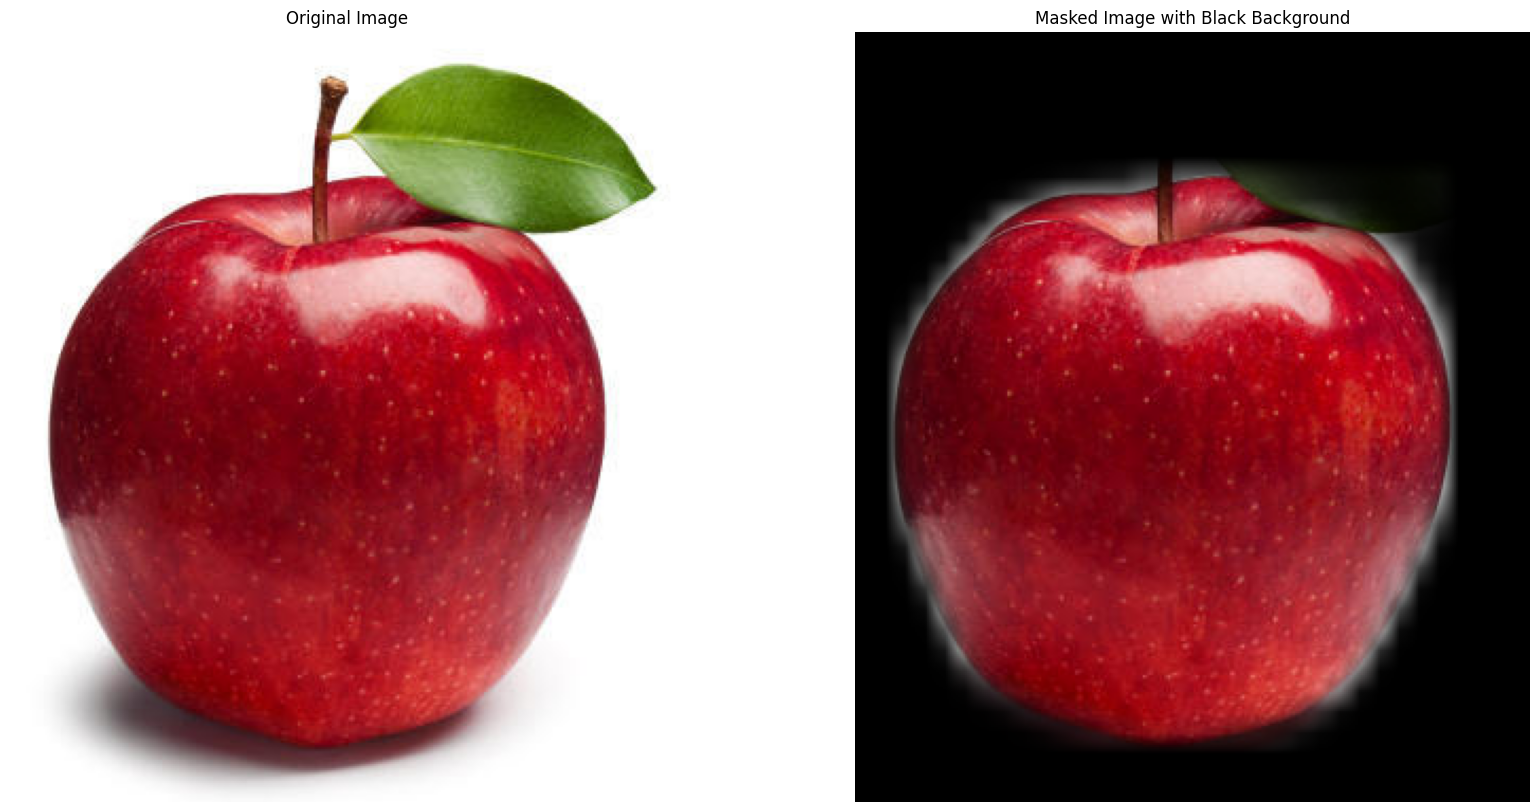

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the image
image_path = 'dataset/images/test_set/apple/apple (1).jpg'
image = Image.open(image_path).convert("RGB")

# Define a transformation to convert the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Convert the image to a tensor
image_tensor = transform(image)

# Load pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Perform inference
with torch.no_grad():
    prediction = model([image_tensor])

# Get the masks and scores
masks = prediction[0]['masks'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Define a threshold for displaying masks and boxes
threshold = 0.5

# Create a combined mask for all objects detected with a score above the threshold
combined_mask = np.zeros_like(masks[0, 0], dtype=np.uint8)
for i in range(len(masks)):
    if scores[i] > threshold:
        combined_mask = np.maximum(combined_mask, masks[i, 0])

# Create a black image
black_image = np.zeros_like(np.array(image))

# Apply the mask to the image
masked_image = np.array(image) * combined_mask[:, :, None]

# Convert the masked image to a PIL image for saving
masked_image_pil = Image.fromarray(masked_image.astype(np.uint8))


# Display the original image and masked image
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(masked_image_pil)
axs[1].set_title("Masked Image with Black Background")
axs[1].axis("off")

plt.show()


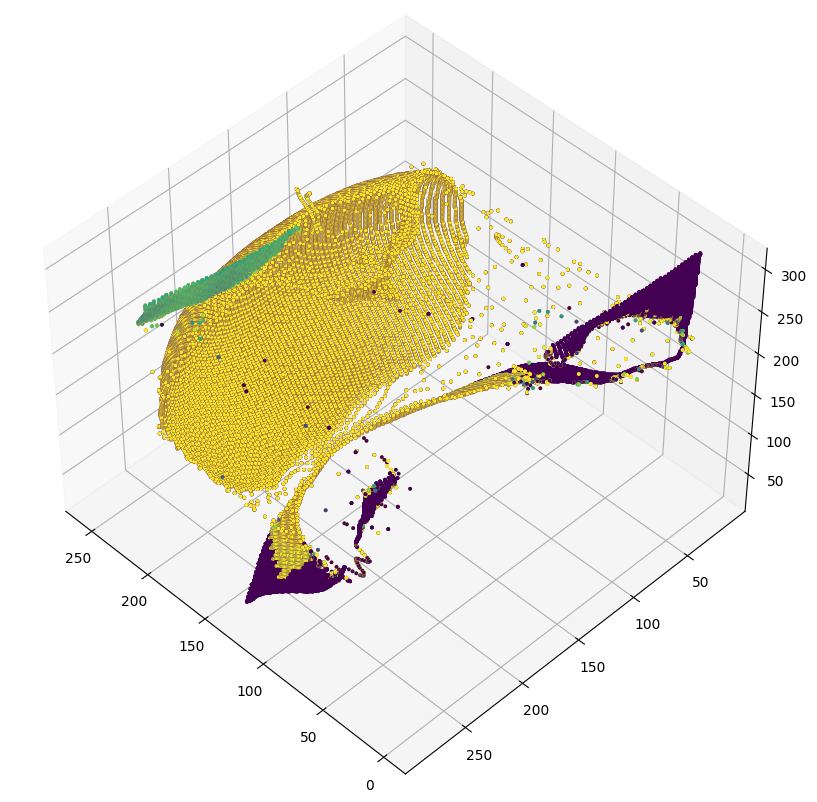

In [ ]:
# import open3d as o3d
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import cv2

# # Load the depth map and color map
# # Replace with the paths to your depth and color images
# depth_map_path = '/content/depth_map.png'
# color_map_path = '/content/dataset/images/test_set/apple/apple (1).jpg'

# # Load images using PIL
# depth_map = np.array(Image.open(depth_map_path))
# color_map = np.array(Image.open(color_map_path))

# # Normalize depth map
# depth_map = depth_map.astype(np.float32)
# depth_map = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX)

# # Create Open3D RGBD image
# color_raw = o3d.geometry.Image(color_map)
# depth_raw = o3d.geometry.Image(depth_map)
# rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)

# # Create camera intrinsic parameters
# width, height = color_map.shape[1], color_map.shape[0]
# intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, 525.0, 525.0, width / 2.0, height / 2.0)

# # Create point cloud from RGBD image
# pcl = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)

# # Flip the point cloud to correct orientation
# pcl.transform([[1, 0, 0, 0],
#                [0, -1, 0, 0],
#                [0, 0, -1, 0],
#                [0, 0, 0, 1]])

# # Visualize the point cloud
# o3d.visualization.draw_geometries([pcl])

# from open3d.web_visualizer import draw

# # Draw the point cloud inline
# # draw(pcl)

# # depth map
# depth_vis = np.flipud(depth_image.squeeze())  # target
# # masked color image
# img_vis = np.flipud(masked_image.squeeze())  # input

# fig = plt.figure(figsize=(15, 10))
# ax = plt.axes(projection="3d")

# STEP = 3
# for x in range(0, img_vis.shape[0], STEP):
#     for y in range(0, img_vis.shape[1], STEP):
#         ax.scatter(
#             [depth_vis[x, y]] * 3,
#             [y] * 3,
#             [x] * 3,
#             c=tuple(img_vis[x, y, :3] / 255),
#             s=3,
#         )
#     ax.view_init(45, 135)
import numpy as np
import matplotlib.pyplot as plt

# Assuming depth_image and masked_image are already defined and processed
depth_vis = np.flipud(depth_image.squeeze())  # target
img_vis = np.flipud(masked_image.squeeze())  # input

# Create a mask for non-black pixels
non_black_mask = np.any(img_vis != 0, axis=-1)

# Filter the depth and color data using the non-black mask
depth_vis_filtered = depth_vis[non_black_mask]
img_vis_filtered = img_vis[non_black_mask]

# Get the x and y coordinates of the non-black pixels
x_coords, y_coords = np.where(non_black_mask)

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

# Plot only the non-black points
STEP = 3
for i in range(0, len(x_coords), STEP):
    x = x_coords[i]
    y = y_coords[i]
    ax.scatter(
        [depth_vis_filtered[i]] * 3,
        [y] * 3,
        [x] * 3,
        c=tuple(img_vis_filtered[i, :3] / 255),
        s=3,
    )

ax.view_init(45, 135)
plt.show()
